In [23]:
# Copyright 2025 The Marin Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""
Read evaluation numbers for math reasoning from exp_isoflop_hf_reasoning_logprobs.py.

This script queries wandb for evaluation results, filtering for successful runs only
and finding the most recent successful run for each model.
"""

import json
import os
import sys
from collections import defaultdict
from typing import Any
from datetime import datetime

import wandb
import pandas as pd
from scipy import stats

import fsspec
from experiments.evals.exp_isoflop_hf_math500 import build_hf_steps, get_step_output_path

# Use the same defaults as the marin codebase
WANDB_ENTITY = os.getenv("WANDB_ENTITY", "marin-community")
WANDB_PROJECT = os.getenv("WANDB_PROJECT", "marin")
WANDB_PATH = f"{WANDB_ENTITY}/{WANDB_PROJECT}"


def is_run_successful(run) -> bool:
    """
    Check if a wandb run completed successfully.

    Args:
        run: wandb.Run object

    Returns:
        True if run finished successfully, False otherwise
    """
    # Check run state - should be "finished" or "completed"
    if run.state not in ["finished", "completed"]:
        return False

    # Check if run has eval metrics (indicates it completed evaluation)
    summary = run.summary or {}
    has_eval_metrics = any(key.startswith("eval/") for key in summary.keys())

    return has_eval_metrics


def extract_model_identifier(run, suffix) -> str:
    """
    Extract a unique model identifier from the run.

    For ISOFlop models: use FLOPs, d (hidden_size), and L (num_layers)
    For HF models: use the model name (M=...)

    Args:
        run: wandb.Run object
        suffix: suffix to split on

    Returns:
        Model identifier string
    """
    
    return run.name.split(suffix)[0]


def extract_bpb_metrics(run) -> dict[str, float]:
    dataset_metrics = {}

    for key in run.summary.keys():
        if not key.endswith("/bpb"):
            continue

        parts = key.split("/bpb")
        metric_name = "".join(parts[:-1])
        dataset_metrics[metric_name] = run.summary[key]

    return dataset_metrics


def query_eval_runs(eval_tag: str) -> dict[str, dict[str, Any]]:
    """
    Query wandb for evaluation runs with a specific tag.

    Returns a dictionary mapping model_id -> most recent successful run data
    """
    api = wandb.Api()

    runs = api.runs(
        path=WANDB_PATH,
        filters={"tags": {"$in": [f"eval={eval_tag}"]}},
        order="-created_at",
    )

    # Group runs by model identifier
    model_runs = defaultdict(list)

    for run in runs:
        model_id = extract_model_identifier(run=run, suffix=f"-{eval_tag}")

        # Parse created_at time
        created_at = run.created_at
        if isinstance(created_at, str):
            created_at = datetime.fromisoformat(created_at.replace('Z', '+00:00'))

        model_runs[model_id].append({
            "run": run,
            "created_at": created_at,
            "is_successful": is_run_successful(run),
        })

    # For each model, find the most recent successful run
    best_runs = {}

    for model_id, runs_list in model_runs.items():
        # Sort by creation time (most recent first)
        runs_list.sort(key=lambda x: x["created_at"], reverse=True)

        # Find first successful run
        successful_run = None
        for run_data in runs_list:
            if run_data["is_successful"]:
                successful_run = run_data
                break

        if successful_run:
            run = successful_run["run"]
            best_runs[model_id] = extract_bpb_metrics(run=run)

    return best_runs

def compute_correlations(df, row_filter=None, column_filter=None, corr_func=None):
    # Apply filters
    if row_filter:
        df = df[df.index.map(row_filter)]
    if column_filter:
        df = df[[col for col in df.columns if column_filter(col)]]
    
    df_clean = df.dropna()
    
    if corr_func is None:
        from scipy.stats import pearsonr
        corr_func = lambda x, y: pearsonr(x, y)[0]
    
    row_corr = df_clean.T.apply(lambda row1: df_clean.T.apply(lambda row2: corr_func(row1.values, row2.values)))
    column_corr = df_clean.apply(lambda col1: df_clean.apply(lambda col2: corr_func(col1.values, col2.values)))
    
    return row_corr, column_corr

def get_flops(model_id):
    return float(model_id.split("-")[1]) if "e+" in model_id else None

# Build the step lookup once (cheap - just constructs the executor graph, doesn't run anything)
_math500_step_map = {}
for _step in build_hf_steps(prompt_format="standard_fewshot"):
    _math500_step_map[_step.name.split("/")[-1]] = _step

def get_math500_metrics(model_id):
    step = _math500_step_map.get(model_id)
    if step is None:
        return None

    output_path = get_step_output_path(step, prefix="gs://marin-us-central1")
    results_file = os.path.join(output_path, "results.json.gz")

    with fsspec.open(results_file, "rt", compression="gzip") as f:
        data = json.load(f)

    return {"pass_at_1": data["pass_at_1"], "pass_at_k": data["pass_at_k"], "k": data["k"]}


2026-02-08 16:28:59,702	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
evals = ["eval/tony-correct","eval/tony-incorrect","eval/deepseek-r1","eval/tony-subquestions"]
def eval_filter(col):
    return col in evals

def isoflop_filter(row):
    return row.startswith("isoflop")

def qwen_filter(row):
    return row.startswith("Qwen")

def qwen3_filter(row):
    return "Qwen3" in row


In [3]:
"""Main function to read and display all eval numbers."""
math_name = "math-reasoning-eval"

math_bpb = query_eval_runs(math_name)
all_models = math_bpb.keys()

full_bpb = {}
for model in all_models:
    full_bpb[model] = math_bpb[model]

df = pd.DataFrame(full_bpb).T
df = df.dropna()

df["flops"] = df.index.map(get_flops)

wandb: [wandb.Api()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.


In [6]:
iso_df = df[df.index.map(lambda x: isoflop_filter(x))]

In [ ]:
hf_df = df[df.index.map(lambda x: not isoflop_filter(x))]
hf_df = hf_df.dropna(axis=1)

In [20]:
model_corr, eval_corr = compute_correlations(hf_df, column_filter=lambda x: "correct" in x and not "incorrect" in x)

In [21]:
eval_corr

,eval/Qwen--Qwen3-0-6B-Base_filter_correct,eval/Qwen--Qwen3-0-6B_filter_correct,eval/Qwen--Qwen3-1-7B-Base_filter_correct,eval/Qwen--Qwen3-1-7B_filter_correct,eval/Qwen--Qwen3-32B_filter_correct,eval/Qwen--Qwen3-4B-Base_filter_correct,eval/Qwen--Qwen3-4B_filter_correct,eval/Qwen--Qwen3-8B-Base_filter_correct,eval/Qwen--Qwen3-8B_filter_correct,eval/allenai--OLMo-2-0325-32B_filter_correct,eval/allenai--OLMo-2-1124-7B_filter_correct,eval/marin-community--marin-8b-base_filter_correct,eval/meta-llama--Llama-3-1-8B_filter_correct,eval/tony-correct
eval/Qwen--Qwen3-0-6B-Base_filter_correct,1.000000,0.309233,0.985983,0.213250,0.048739,0.969434,0.140208,0.962497,0.193799,0.725718,0.375305,0.699401,0.416481,0.612452
eval/Qwen--Qwen3-0-6B_filter_correct,0.309233,1.000000,0.350552,0.915517,0.826690,0.345296,0.867690,0.327966,0.841121,0.319087,-0.336869,0.212776,-0.318058,0.489428
eval/Qwen--Qwen3-1-7B-Base_filter_correct,0.985983,0.350552,1.000000,0.296300,0.143440,0.991899,0.229700,0.983054,0.288996,0.752564,0.371461,0.716759,0.420921,0.703387
eval/Qwen--Qwen3-1-7B_filter_correct,0.213250,0.915517,0.296300,1.000000,0.907679,0.293824,0.955436,0.270586,0.935344,0.275538,-0.364622,0.161096,-0.407212,0.503836
eval/Qwen--Qwen3-32B_filter_correct,0.048739,0.826690,0.143440,0.907679,1.000000,0.174008,0.963358,0.144896,0.966284,0.255451,-0.295057,0.121803,-0.320544,0.567234
eval/Qwen--Qwen3-4B-Base_filter_correct,0.969434,0.345296,0.991899,0.293824,0.174008,1.000000,0.244759,0.994095,0.308691,0.757313,0.377682,0.712701,0.456890,0.753840
eval/Qwen--Qwen3-4B_filter_correct,0.140208,0.867690,0.229700,0.955436,0.963358,0.244759,1.000000,0.216713,0.987140,0.246224,-0.355674,0.140345,-0.379267,0.530216
eval/Qwen--Qwen3-8B-Base_filter_correct,0.962497,0.327966,0.983054,0.270586,0.144896,0.994095,0.216713,1.000000,0.277492,0.703916,0.319352,0.653815,0.433500,0.723345
eval/Qwen--Qwen3-8B_filter_correct,0.193799,0.841121,0.288996,0.935344,0.966284,0.308691,0.987140,0.277492,1.000000,0.329863,-0.262633,0.221930,-0.314412,0.613889
eval/allenai--OLMo-2-0325-32B_filter_correct,0.725718,0.319087,0.752564,0.275538,0.255451,0.757313,0.246224,0.703916,0.329863,1.000000,0.667744,0.848256,0.622614,0.831437


In [22]:
full_bpb

{'Qwen--Qwen3-8B': {'eval/Qwen--Qwen3-0-6B-Base_filter_all': 0.20852044224739075,
  'eval/Qwen--Qwen3-0-6B-Base_filter_correct': 0.20853979885578156,
  'eval/Qwen--Qwen3-0-6B-Base_filter_incorrect': 0.2089931070804596,
  'eval/Qwen--Qwen3-0-6B_filter_all': 0.07131759077310562,
  'eval/Qwen--Qwen3-0-6B_filter_correct': 0.07598362118005753,
  'eval/Qwen--Qwen3-0-6B_filter_incorrect': 0.07096671313047409,
  'eval/Qwen--Qwen3-1-7B-Base_filter_all': 0.1946079432964325,
  'eval/Qwen--Qwen3-1-7B-Base_filter_correct': 0.19873030483722687,
  'eval/Qwen--Qwen3-1-7B-Base_filter_incorrect': 0.1932680606842041,
  'eval/Qwen--Qwen3-1-7B_filter_all': 0.09561136364936829,
  'eval/Qwen--Qwen3-1-7B_filter_correct': 0.11367406696081161,
  'eval/Qwen--Qwen3-1-7B_filter_incorrect': 0.08940654993057251,
  'eval/Qwen--Qwen3-32B_filter_all': 0.1057114452123642,
  'eval/Qwen--Qwen3-32B_filter_correct': 0.1110643818974495,
  'eval/Qwen--Qwen3-32B_filter_incorrect': 0.10374369472265244,
  'eval/Qwen--Qwen3-4B-Ba

In [28]:
metrics_hf_df = pd.DataFrame(hf_df.index.map(get_math500_metrics).tolist(), index=hf_df.index)
full_hf_df = pd.concat([hf_df, metrics_hf_df], axis=1)

2026-02-08 16:47:41,191	WARNING executor.py:1040 -- Output path gs://marin-us-central1/models/Qwen--Qwen3-8B--main-2cc4f4 doesn't match given override models/Qwen--Qwen3-8B--main, using the latter.
2026-02-08 16:47:41,856	WARNING executor.py:1040 -- Output path gs://marin-us-central1/models/Qwen--Qwen3-0-6B-Base--main-8a5bbf doesn't match given override models/Qwen--Qwen3-0-6B-Base--main, using the latter.
2026-02-08 16:47:42,232	WARNING executor.py:1040 -- Output path gs://marin-us-central1/models/allenai--OLMo-2-0325-32B--main-3ae7aa doesn't match given override models/allenai--OLMo-2-0325-32B--main, using the latter.
2026-02-08 16:47:42,629	WARNING executor.py:1040 -- Output path gs://marin-us-central1/models/Qwen--Qwen3-4B--main-79e048 doesn't match given override models/Qwen--Qwen3-4B--main, using the latter.
2026-02-08 16:47:43,187	WARNING executor.py:1040 -- Output path gs://marin-us-central1/models/Qwen--Qwen3-1-7B--main-cc3e3d doesn't match given override models/Qwen--Qwen3-1-

In [30]:
full_hf_df["pass_at_k"]

Qwen--Qwen3-8B                    0.604
Qwen--Qwen3-0-6B-Base             0.520
allenai--OLMo-2-0325-32B          0.114
Qwen--Qwen3-4B                    0.654
Qwen--Qwen3-1-7B                  0.532
Qwen--Qwen3-0-6B                  0.144
Qwen--Qwen3-8B-Base               0.706
Qwen--Qwen3-32B                   0.722
allenai--OLMo-2-1124-7B           0.032
Qwen--Qwen3-4B-Base               0.668
Qwen--Qwen3-1-7B-Base             0.452
marin-community--marin-8b-base    0.010
meta-llama--Llama-3-2-1B          0.000
meta-llama--Llama-3-1-8B          0.002
Name: pass_at_k, dtype: float64

In [36]:
model_corr, eval_corr = compute_correlations(full_hf_df, row_filter=qwen_filter)

In [38]:
eval_corr

,eval/Qwen--Qwen3-0-6B-Base_filter_all,eval/Qwen--Qwen3-0-6B-Base_filter_correct,eval/Qwen--Qwen3-0-6B-Base_filter_incorrect,eval/Qwen--Qwen3-0-6B_filter_all,eval/Qwen--Qwen3-0-6B_filter_correct,eval/Qwen--Qwen3-0-6B_filter_incorrect,eval/Qwen--Qwen3-1-7B-Base_filter_all,eval/Qwen--Qwen3-1-7B-Base_filter_correct,eval/Qwen--Qwen3-1-7B-Base_filter_incorrect,eval/Qwen--Qwen3-1-7B_filter_all,...,eval/meta-llama--Llama-3-1-8B_filter_correct,eval/meta-llama--Llama-3-1-8B_filter_incorrect,eval/meta-llama--Llama-3-2-1B_filter_all,eval/meta-llama--Llama-3-2-1B_filter_incorrect,eval/tony-correct,eval/tony-incorrect,eval/tony-subquestions,pass_at_1,pass_at_k,k
eval/Qwen--Qwen3-0-6B-Base_filter_all,1.000000,0.997948,0.999874,-0.227307,-0.624057,-0.161840,0.970941,0.967350,0.971759,-0.868051,...,0.668366,0.403183,0.460119,0.460117,0.263707,0.332031,0.466524,-0.222834,-0.052530,NaN
eval/Qwen--Qwen3-0-6B-Base_filter_correct,0.997948,1.000000,0.996807,-0.259479,-0.648793,-0.194452,0.981105,0.979754,0.981074,-0.856921,...,0.687314,0.369335,0.513061,0.513059,0.308321,0.373204,0.500343,-0.269441,-0.103443,NaN
eval/Qwen--Qwen3-0-6B-Base_filter_incorrect,0.999874,0.996807,1.000000,-0.219037,-0.617445,-0.153492,0.967796,0.963658,0.968822,-0.870437,...,0.663426,0.411071,0.446763,0.446761,0.252704,0.321842,0.458006,-0.211170,-0.039917,NaN
eval/Qwen--Qwen3-0-6B_filter_all,-0.227307,-0.259479,-0.219037,1.000000,0.890308,0.997473,-0.315265,-0.336377,-0.306877,0.169831,...,-0.254965,0.158069,-0.513631,-0.513630,-0.325335,-0.304079,-0.414618,0.862904,0.749169,NaN
eval/Qwen--Qwen3-0-6B_filter_correct,-0.624057,-0.648793,-0.617445,0.890308,1.000000,0.855751,-0.693730,-0.707482,-0.687871,0.544279,...,-0.580890,0.022612,-0.606059,-0.606056,-0.463997,-0.479912,-0.631705,0.795699,0.657807,NaN
eval/Qwen--Qwen3-0-6B_filter_incorrect,-0.161840,-0.194452,-0.153492,0.997473,0.855751,1.000000,-0.250609,-0.272392,-0.242017,0.107707,...,-0.197863,0.173195,-0.487988,-0.487988,-0.294868,-0.268324,-0.370809,0.855228,0.747195,NaN
eval/Qwen--Qwen3-1-7B-Base_filter_all,0.970941,0.981105,0.967796,-0.315265,-0.693730,-0.250609,1.000000,0.998886,0.999841,-0.787648,...,0.745110,0.290079,0.595596,0.595592,0.424783,0.482991,0.608655,-0.330501,-0.199325,NaN
eval/Qwen--Qwen3-1-7B-Base_filter_correct,0.967350,0.979754,0.963658,-0.336377,-0.707482,-0.272392,0.998886,1.000000,0.997887,-0.788149,...,0.753217,0.262980,0.624628,0.624624,0.446542,0.502298,0.621077,-0.364219,-0.233732,NaN
eval/Qwen--Qwen3-1-7B-Base_filter_incorrect,0.971759,0.981074,0.968822,-0.306877,-0.687871,-0.242017,0.999841,0.997887,1.000000,-0.786795,...,0.741297,0.300522,0.584339,0.584335,0.415935,0.475024,0.603171,-0.317291,-0.185887,NaN
eval/Qwen--Qwen3-1-7B_filter_all,-0.868051,-0.856921,-0.870437,0.169831,0.544279,0.107707,-0.787648,-0.788149,-0.786795,1.000000,...,-0.670321,-0.186683,-0.342321,-0.342326,-0.269327,-0.334714,-0.430446,0.253123,0.037733,NaN


In [40]:
top10 = eval_corr.sort_values(by="pass_at_1", ascending=True).head(10)["pass_at_1"]
print(top10)

top10 = eval_corr.sort_values(by="pass_at_k", ascending=True).head(10)["pass_at_k"]
print(top10)

eval                                                 -0.746521
eval/meta-llama--Llama-3-2-1B_filter_incorrect       -0.720046
eval/meta-llama--Llama-3-2-1B_filter_all             -0.720046
eval/marin-community--marin-8b-base_filter_correct   -0.627947
eval/tony-correct                                    -0.616446
eval/tony-subquestions                               -0.597525
eval/tony-incorrect                                  -0.590609
eval/allenai--OLMo-2-1124-7B_filter_correct          -0.582640
eval/allenai--OLMo-2-0325-32B_filter_all             -0.553825
eval/allenai--OLMo-2-0325-32B_filter_incorrect       -0.553815
Name: pass_at_1, dtype: float64
eval/tony-correct                                    -0.772904
eval                                                 -0.763105
eval/tony-incorrect                                  -0.736573
eval/tony-subquestions                               -0.720150
eval/meta-llama--Llama-3-2-1B_filter_all             -0.624445
eval/meta-llama--Llama-

x: pass_at_1
y: pass_at_k


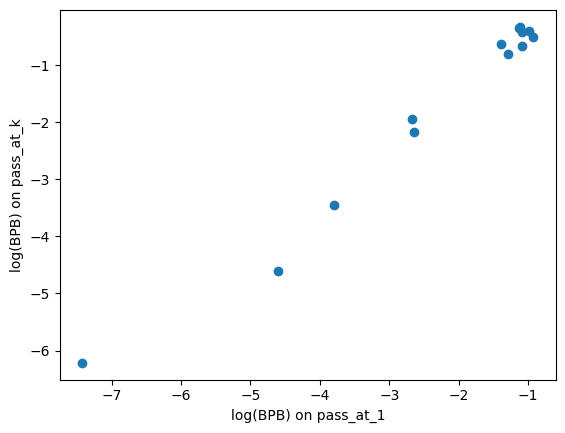

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_set = "pass_at_1" # "eval/paloma/dolma-v1_5" # "eval/tony-correct"# "eval/paloma/4chan"
y_set = "pass_at_k"

print(f"x: {x_set}")
print(f"y: {y_set}")

plot_df = full_hf_df
y = [np.log(bpb) for bpb in plot_df[y_set].to_list()]
x = [np.log(bpb) for bpb in plot_df[x_set].to_list()]

plt.scatter(x, y)

plt.xlabel(f"log(BPB) on {x_set}")
plt.ylabel(f"log(BPB) on {y_set}")
plt.show()


x: eval/meta-llama--Llama-3-2-1B_filter_incorrect
y: pass_at_1


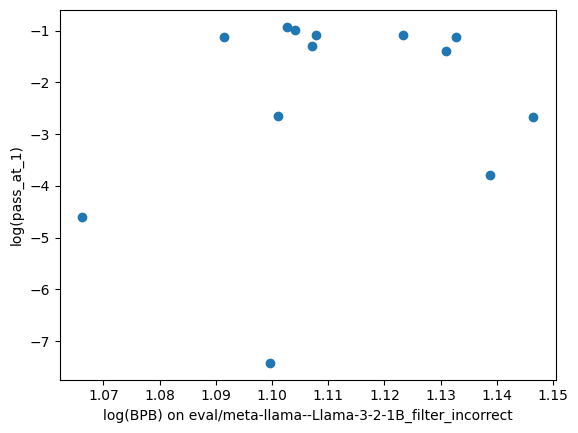

In [51]:
import matplotlib.pyplot as plt
import numpy as np

x_set = "eval/meta-llama--Llama-3-2-1B_filter_incorrect"
k = 1


y_set = f"pass_at_{k}"

print(f"x: {x_set}")
print(f"y: {y_set}")

plot_df = full_hf_df
y = [np.log(bpb) for bpb in plot_df[y_set].to_list()]
x = [np.log(bpb) for bpb in plot_df[x_set].to_list()]

plt.scatter(x, y)

plt.xlabel(f"log(BPB) on {x_set}")
plt.ylabel(f"log(pass_at_{k})")
plt.show()


In [49]:
y

[np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan)]